In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPool2D
import cv2



In [2]:
df = pd.read_csv('data/crop_detection/Crop_details.csv')
df.head()

,Unnamed: 0,path,crop,croplabel
0,0,/kaggle/input/kag2/sugarcane/sugarcane037ahs.jpeg,sugarcane,3
1,1,/kaggle/input/kag2/sugarcane/sugarcane034a.jpeg,sugarcane,3
2,2,/kaggle/input/kag2/sugarcane/sugarcane032arot....,sugarcane,3
3,3,/kaggle/input/kag2/sugarcane/sugarcane036ahs.jpeg,sugarcane,3
4,4,/kaggle/input/kag2/sugarcane/sugarcane023ahs.jpeg,sugarcane,3


In [3]:
categories = os.listdir('data/crop_detection/kag2')
categories

['jute', 'maize', 'rice', 'sugarcane', 'wheat']

In [4]:
getData = ImageDataGenerator(rescale=1/255,
                             shear_range=0.3,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=90)

In [6]:
kag2_data = getData.flow_from_directory("data/crop_detection/kag2",
                                        target_size=(224,224),
                                        class_mode='categorical',
                                        shuffle=True,
                                        batch_size=32)

Found 804 images belonging to 5 classes.


In [8]:
vgg_model = VGG16(input_shape=(224,224,3),
                  include_top=False,
                  weights='imagenet',
                  pooling='avg')
for layers in vgg_model.layers:
    layers.trainable = False

58889256/58889256 [==============================] - 616s 10us/step


In [9]:
model = Sequential()
model.add(vgg_model)
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(5,activation="softmax"))

In [13]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 15,043,653
Trainable params: 328,965
Non-t

In [15]:
num_train_samples = 804
batch_size = 64
epochs = 50

final_model = model.fit_generator(kag2_data,
                                  steps_per_epoch=num_train_samples/batch_size,
                                  epochs=epochs)

/tmp/ipykernel_131823/4292572090.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  final_model = model.fit_generator(kag2_data,


Epoch 1/50


2023-06-28 15:49:03.034854: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2023-06-28 15:49:04.303185: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19267584 exceeds 10% of free system memory.
2023-06-28 15:49:04.317260: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-06-28 15:49:04.761646: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


12/12 [==============================] - 125s 10s/step - loss: 1.6992 - accuracy: 0.2019
Epoch 2/50
12/12 [==============================] - 97s 8s/step - loss: 1.5987 - accuracy: 0.2577
Epoch 3/50
12/12 [==============================] - 103s 8s/step - loss: 1.5460 - accuracy: 0.3029
Epoch 4/50
12/12 [==============================] - 102s 8s/step - loss: 1.4823 - accuracy: 0.3822
Epoch 5/50
12/12 [==============================] - 106s 8s/step - loss: 1.3714 - accuracy: 0.4375
Epoch 6/50
12/12 [==============================] - 122s 10s/step - loss: 1.3793 - accuracy: 0.4046
Epoch 7/50
12/12 [==============================] - 123s 10s/step - loss: 1.2955 - accuracy: 0.4928
Epoch 8/50
12/12 [==============================] - 115s 9s/step - loss: 1.2346 - accuracy: 0.5120
Epoch 9/50
12/12 [==============================] - 114s 9s/step - loss: 1.2388 - accuracy: 0.4880
Epoch 10/50
12/12 [==============================] - 110s 9s/step - loss: 1.2223 - accuracy: 0.4794
Epoch 11/50
12/12 

In [16]:
test_datagen = ImageDataGenerator(rescale=1/255)
crop_data = test_datagen.flow_from_directory('data/crop_detection/crop_images',
                                             target_size=(224,224),
                                             class_mode='categorical',
                                             shuffle=True,
                                             batch_size=32)

Found 201 images belonging to 5 classes.


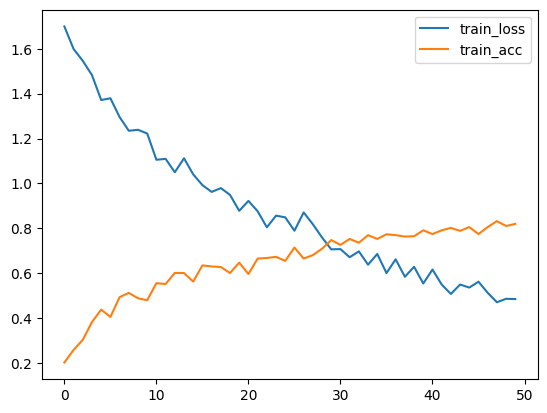

In [17]:
plt.plot(final_model.history['loss'],label='train_loss')
plt.plot(final_model.history['accuracy'],label="train_acc")
plt.legend()
plt.show()

In [18]:
class_labels = crop_data.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
Y_pred = model.predict_generator(crop_data)
y_pred = np.argmax(Y_pred, axis = 1)

/tmp/ipykernel_131823/775190283.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(crop_data)


In [19]:
def predict_crop(path, actual, class_labels):
    img = cv2.imread(path)
    img = cv2.resize(img, (224,224))
    img = np.array(img).reshape((1,224,224,3))
    Y_pred = model.predict(img)
    y_pred = np.argmax(Y_pred, axis=1)
    if y_pred == actual:
        print("Correct Prediction")
    else:
        print("Wrong Prediction")
    print('Accual class "{0}" and predicted class "{1}"'.format(class_labels[int(y_pred)],class_labels[actual]))
    
    

In [20]:
predict_crop('data/crop_detection/kag2/rice/rice024ahs.jpeg',2,class_labels)

1/1 [==============================] - 1s 585ms/step
Wrong Prediction
Accual class "maize" and predicted class "rice"


In [21]:
predict_crop('data/crop_detection/test_crop_image/sugarcane fields.jpg',3,class_labels)

1/1 [==============================] - 0s 310ms/step
Wrong Prediction
Accual class "maize" and predicted class "sugarcane"
